In [ ]:
# ! pip install yfinance --upgrade --no-cache-dir

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics import tsaplots
from sklearn.model_selection import TimeSeriesSplit

import yfinance as yf

plt.style.use('ggplot')



In [14]:
window = 6


series = pd.read_csv('data/weather_data.csv').iloc[:, 0]

# calculate the mean with a rolling window aka moving average
series.rolling(window, center=True)

Rolling [window=6,center=True,axis=0]

# Time Series

(based heavily on Matt Drury and Ryan Kasichainula's notebooks)

Success Criteria:

Today I will be successful if I can...

- Imagine multiple scenarios that require a time-series analysis
- Discuss what is meant by autocorrelation
- Define a time-series trend and list several ways the trend in a time series could be determined.
- Define a time-series season and explain how seasonality of a time series can be determined.
- Explain the problem with cross-validating time-series models and how to do it correctly.


## What is time series data?

A **time series** is data measured over a period of time.


#### Why do we care?

Time series data is often **periodic** and exhibits **autocorrelation**, and these qualities can interfere with doing regression. 


<!-- periodicity: you'll have facts that depend on moth...quarter...week.... 
Like temperature (daily variation) 
Traffic density (monthly variation) -->

In [18]:
weather = pd.read_csv('data/weather_data.csv', index_col=0, parse_dates=True)

In [19]:
weather.tail()

,MaxTemp,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm
Date,,,,,,,
2017-12-28,30.7,12.1,76.0,38,15,1016.1,1010.8
2017-12-29,28.4,12.7,48.0,45,22,1020.0,1016.9
2017-12-30,19.9,5.3,43.0,63,47,1024.0,1022.8
2017-12-31,26.9,7.1,46.0,69,39,1021.0,1016.2
2018-01-01,30.2,12.6,78.0,43,13,1009.6,1009.2


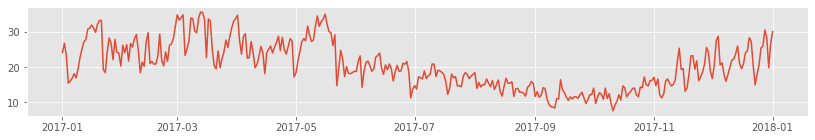

In [21]:
fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(weather.index, weather.MaxTemp);

My target needs to be the temp of however many days out I want to predict.  In this case we are just trying to predict one day out. So the data from previous points will be used.

In [50]:
y = weather.MaxTemp

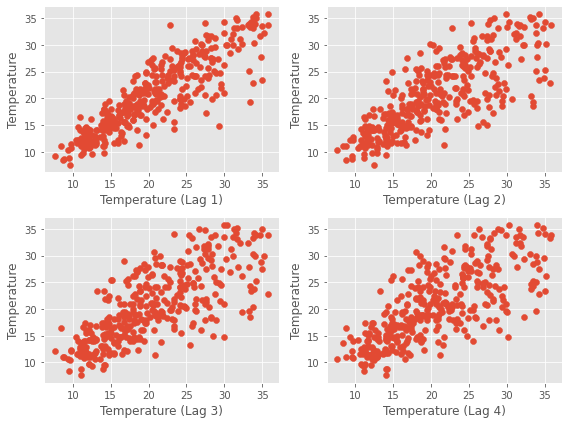

In [27]:
fig, ax = plt.subplots(2,2, figsize = (8, 6))

for i in range(4):
    ax[i//2, i%2].scatter(y.shift(i+1), y)
    ax[i//2, i%2].set_ylabel('Temperature')
    ax[i//2, i%2].set_xlabel('Temperature (Lag {})'.format(i+1))
fig.tight_layout()    

The basic idea of time series is that we use previous time readings as our features for predicting feature values.  Univariate times series focuses on using only one feature which is just 'lagged' values of the target.  Below is an example of doing that with our current dataset.

Y is the actual temp for the given day and the 5 L fields are the values from the previous days

In [33]:
['y'] + ['L%s' % i for i in range(1, 6)]

['y', 'L1', 'L2', 'L3', 'L4', 'L5']

In [31]:
X = (pd.concat([y.shift(i) for i in range(6)], axis=1,
               keys=['y'] + ['L%s' % i for i in range(1, 6)])
       .dropna())
X.head()

,y,L1,L2,L3,L4,L5
Date,,,,,,
2017-01-06,16.9,16.1,15.5,23.4,26.9,24.3
2017-01-07,18.2,16.9,16.1,15.5,23.4,26.9
2017-01-08,17.0,18.2,16.9,16.1,15.5,23.4
2017-01-09,19.5,17.0,18.2,16.9,16.1,15.5
2017-01-10,22.8,19.5,17.0,18.2,16.9,16.1


In [51]:
y.shift(2)

Date
2017-01-01     NaN
2017-01-02     NaN
2017-01-03    24.3
2017-01-04    26.9
2017-01-05    23.4
              ... 
2017-12-28    25.5
2017-12-29    26.1
2017-12-30    30.7
2017-12-31    28.4
2018-01-01    19.9
Name: MaxTemp, Length: 366, dtype: float64

<AxesSubplot:xlabel='Date'>

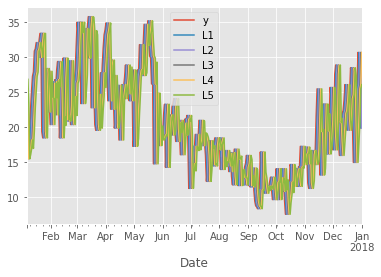

In [41]:
X.plot.line()

When we have many features we do the same thing just ending up with a lot more columns.

In [46]:
#define the ticker symbol
tickerSymbol = 'AAPL'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2021-4-30')

#see your data
tickerDf.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-04-23,131.935898,134.890871,131.935898,134.092239,78657500,0.0,0.0
2021-04-26,134.601376,134.830982,133.333525,134.491562,66905100,0.0,0.0
2021-04-27,134.781053,135.180384,133.882585,134.162109,66015800,0.0,0.0
2021-04-28,134.082243,134.791046,132.854333,133.353485,107760100,0.0,0.0
2021-04-29,136.238598,136.837586,132.225410,133.253662,151101000,0.0,0.0


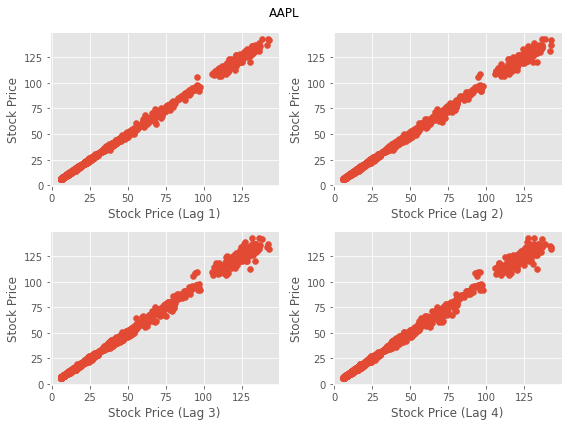

In [47]:
y = tickerDf.Close

fig, ax = plt.subplots(2,2, figsize = (8, 6))

for i in range(4):
    ax[i//2, i%2].scatter(y.shift(i+1), y)
    ax[i//2, i%2].set_ylabel('Stock Price')
    ax[i//2, i%2].set_xlabel('Stock Price (Lag {})'.format(i+1))
fig.suptitle(tickerSymbol)
fig.tight_layout()    

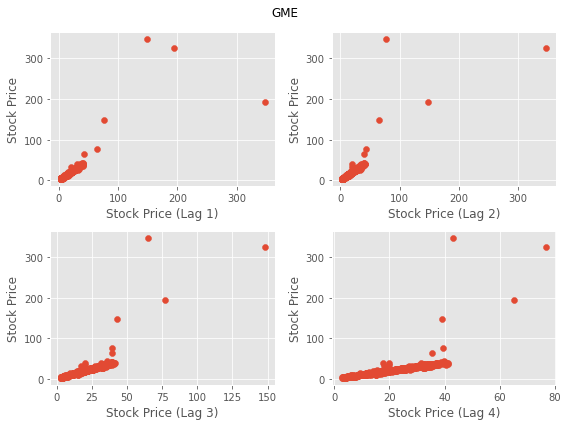

In [52]:
tickerSymbol = 'GME'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2021-1-31')

y = tickerDf.Close

fig, ax = plt.subplots(2,2, figsize = (8, 6))

for i in range(4):
    ax[i//2, i%2].scatter(y.shift(i+1), y)
    ax[i//2, i%2].set_ylabel('Stock Price')
    ax[i//2, i%2].set_xlabel('Stock Price (Lag {})'.format(i+1))
fig.suptitle(tickerSymbol)
fig.tight_layout()    

# Univariate Time Series - Fundamental Concepts 

### Examples

A good source for time series data is [google trends](https://www.google.com/trends/) where you can find how the popularity of a search term varies over time:

We've provided some chosen google trends in the `data` directory.

In [54]:
# '.'.join('.', 'data', ''.join(['search-index-', 'test', '.txt']))

In [55]:
def load_google_trend_data(name):
    """Load saved data for a google trend.
    
    NOTE: For this to work you need to have started your notebook from the
    lecture directory.
    """
    file_name = os.path.join('.', 'data', ''.join(['search-index-', name, '.txt']))
    df = pd.read_csv(file_name)
    df = df.set_index(pd.DatetimeIndex(df.week))
    del df['week']
    return pd.Series(df[name], df.index)

Let's plot these trends and look for some interesting patterns.

In [56]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Google Search Trend For {}".format(name))

In [60]:
google_search_names = ['baseball', 'python', 'pokemon', 'taxes', 'gdp', 'gmail', 'blackberry', 'data-science']

google_trends = {
    name: load_google_trend_data(name)
    for name in google_search_names
}

In [71]:
google_trends['baseball']

week
2011-10-08    46
2011-10-15    41
2011-10-22    52
2011-10-29    31
2011-11-05    28
              ..
2016-08-27    43
2016-09-03    42
2016-09-10    41
2016-09-17    40
2016-09-24    47
Name: baseball, Length: 260, dtype: int64

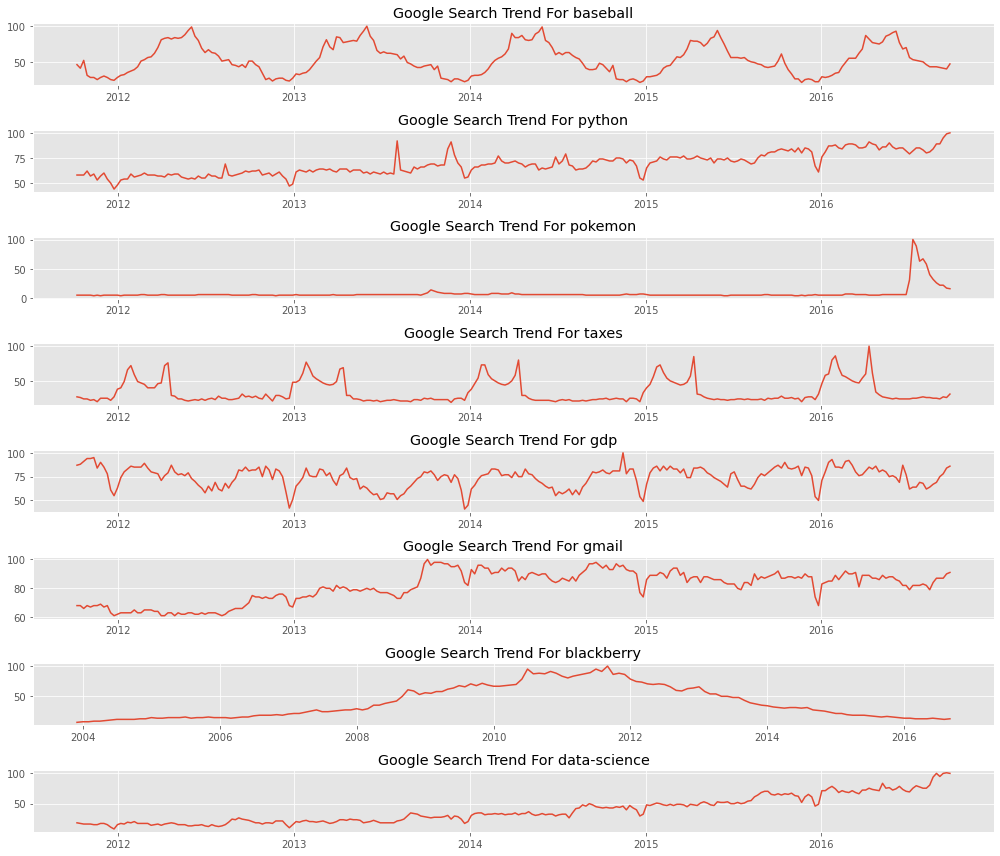

In [65]:
fig, axs = plt.subplots(len(google_trends), figsize=(14, 12))

for ax, name in zip(axs, google_search_names):
    plot_trend_data(ax, name, load_google_trend_data(name))
    
plt.tight_layout()

## Basic Concepts

Various different time series often show common patterns.  Attaching words to these patterns allows us to build a common language to discuss time series.

### Trends

A **trend** in a time series is a gradual change in average level as time moves on.  A trend can be *increasing*, *decreasing*, or *neither* (if, for example, a trend changes direction at some point in time). 

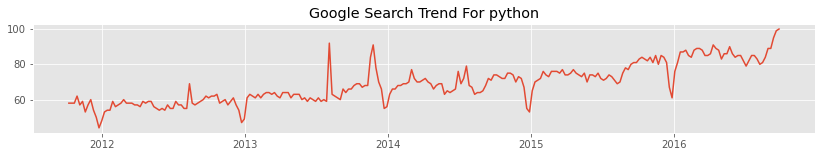

In [66]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'python', google_trends['python'])

Searches for **blackberry** show a non-linear trend.

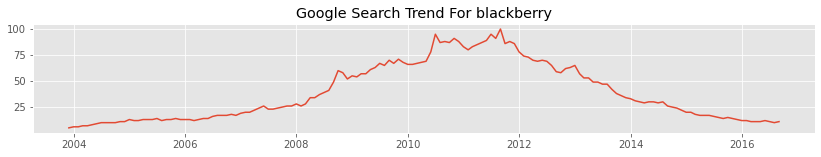

In [67]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'blackberry', google_trends['blackberry'])

You can often use a regression model to capture a general trend in the series.

Let's try to capture the linear trend in the python search data by fitting a simple linear model and using its predictions on the training data.

In [72]:
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

In [74]:
def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

In [75]:
def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

In [77]:
 google_trends['python']

week
2011-10-08     58
2011-10-15     58
2011-10-22     58
2011-10-29     62
2011-11-05     57
             ... 
2016-08-27     89
2016-09-03     89
2016-09-10     95
2016-09-17     99
2016-09-24    100
Name: python, Length: 260, dtype: int64

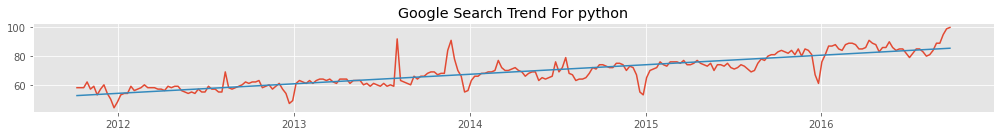

In [76]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_linear_trend(ax, 'python', google_trends['python'])
plt.tight_layout()

If we subtract out the fit trend from the original series, we get the **detrended series**.

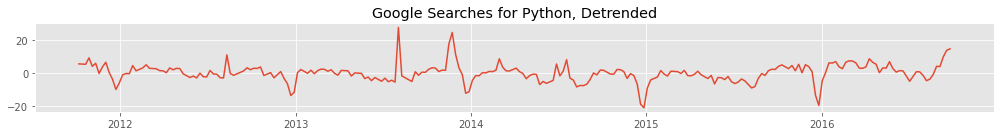

In [78]:
python_series = google_trends['python']
python_linear_trend = fit_linear_trend(python_series)
python_series_detrended = python_series - python_linear_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(python_series_detrended.index, python_series_detrended)
ax.set_title("Google Searches for Python, Detrended")
plt.tight_layout()

Detrending a series is often times a first step in analysing a time series.

Many times time series show a more sophisticated trend than a simple linear increase or decrease, in these cases a more sophisticated detrending procedure is needed.

In the following two cases, a linear detrending would be clearly inappropriate.

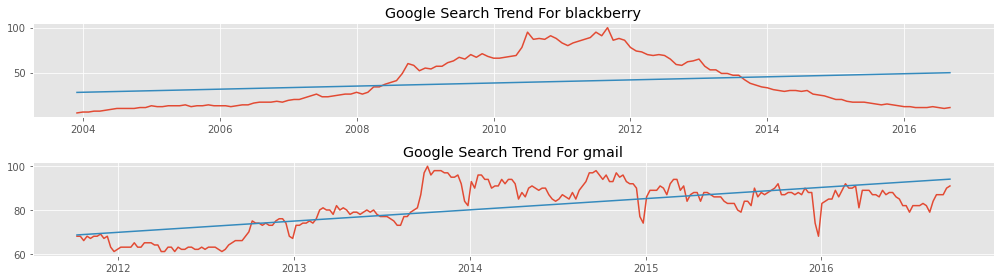

In [79]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_linear_trend(axs[0], 'blackberry', google_trends['blackberry'])
plot_linear_trend(axs[1], 'gmail', google_trends['gmail'])
plt.tight_layout()

**Question:** Can you describe preciesely what is wrong with the linear model in both of these cases?

A very general approach that can be used for detrending data is to compute a **moving average**.

The moving average estimate of the trend at a data point $y_i$ is

$$ \hat y_i = \frac{1}{2w + 1} \sum_{j = -w}^{w} y_{i + j} $$

We esentially slide a *window* of a fixed side across our data, and average the values of the series within the window.

The parameter $w$ controls how far to the left and to the right of $w_i$ we look when averaging the nearby points, this is called the **window**.

In [80]:
def fit_moving_average_trend(series, window=6, center=True):
    return series.rolling(window, center=center).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

In [83]:
google_trends['python'].rolling(2).mean()

week
2011-10-08     NaN
2011-10-15    58.0
2011-10-22    58.0
2011-10-29    60.0
2011-11-05    59.5
              ... 
2016-08-27    86.5
2016-09-03    89.0
2016-09-10    92.0
2016-09-17    97.0
2016-09-24    99.5
Name: python, Length: 260, dtype: float64

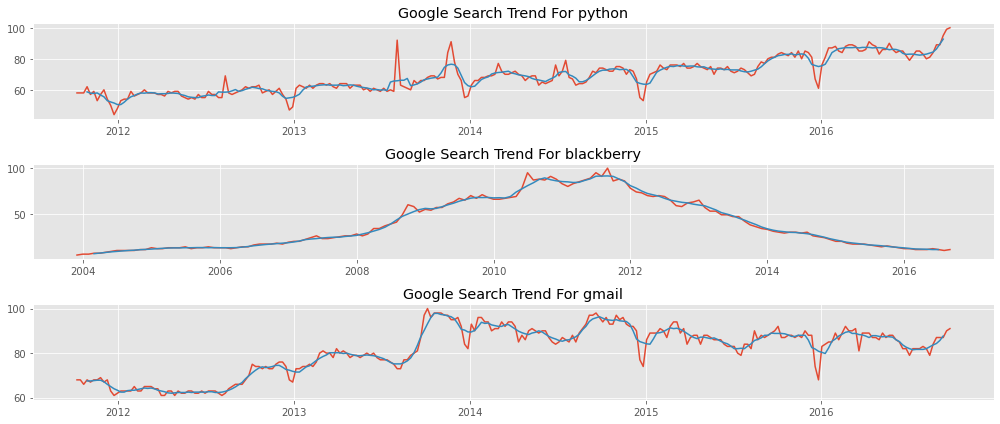

In [81]:
fig, axs = plt.subplots(3, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'python', google_trends['python'])
plot_moving_average_trend(axs[1], 'blackberry', google_trends['blackberry'])
plot_moving_average_trend(axs[2], 'gmail', google_trends['gmail'])
plt.tight_layout()

Varying the window parameter changes the quality of the moving average fit

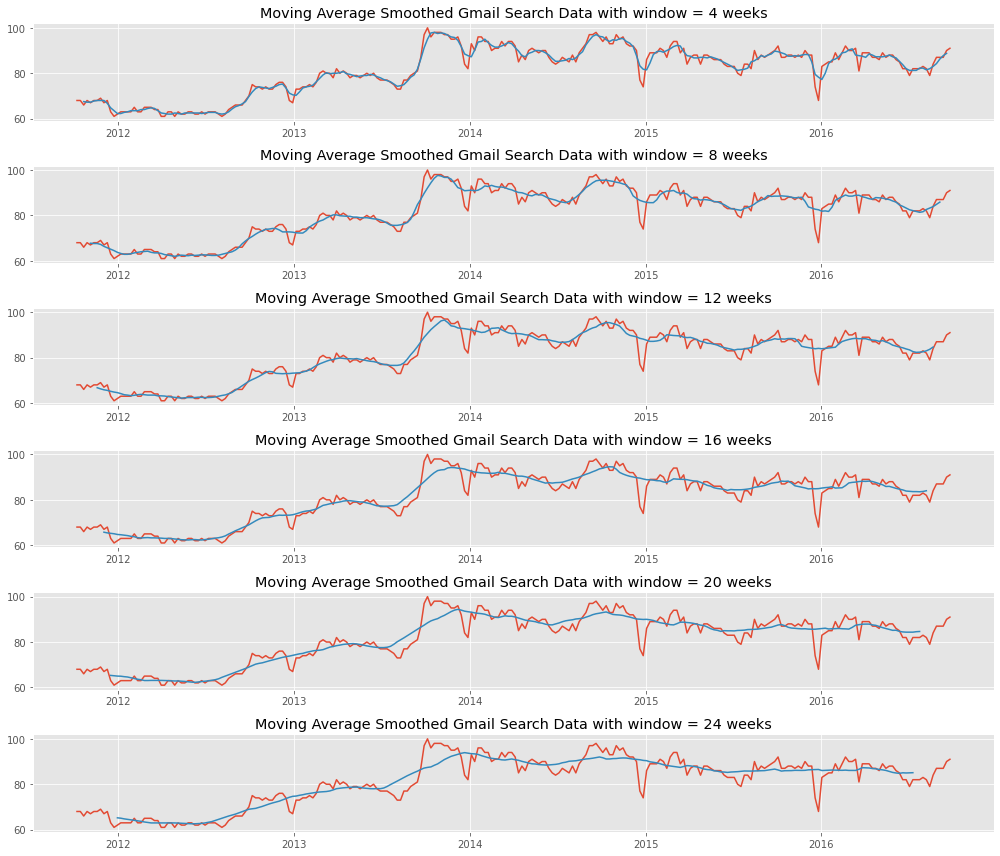

In [84]:
fig, axs = plt.subplots(6, figsize=(14, 12))

gmail_series = google_trends['gmail']
for i, window in enumerate([4, 8, 12, 16, 20, 24]):
    axs[i].plot(gmail_series.index, gmail_series)
    axs[i].plot(gmail_series.index, fit_moving_average_trend(gmail_series, window=window))
    axs[i].set_title("Moving Average Smoothed Gmail Search Data with window = {} weeks".format(window))
    
plt.tight_layout()

We see that:

  - Smaller values of `window` will tend to be influenced by noise of other non-trend patterns in the series.
  - Large values of `window` produce smoother estimates of the general trend in the data.
  
For this reason, when estimating the trend component of a time series, we generally prefer larger windows.

When we have data that aligns with calendar regularities (quarterly, weekly, yearly), it is a good idea to chose the window so that an entire annual cycle is used in the smooth.  This will average out any **seasonal** patterns in the data, as we will discuss below.

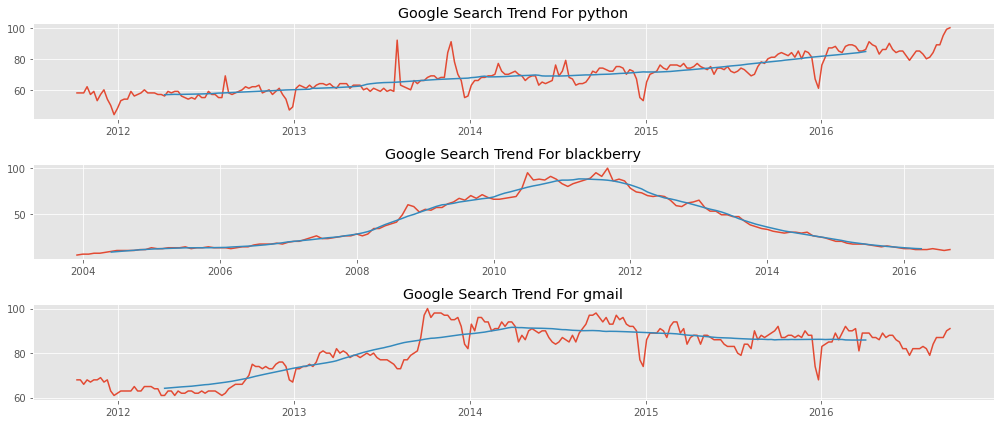

In [85]:
fig, axs = plt.subplots(3, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'python', google_trends['python'], window=52)
plot_moving_average_trend(axs[1], 'blackberry', google_trends['blackberry'], window=12)
plot_moving_average_trend(axs[2], 'gmail', google_trends['gmail'], window=52)
plt.tight_layout()

### Seasonality

A **seasonal** pattern in a time series is one that tends to appear regularly, and aligns with features of the calendar.

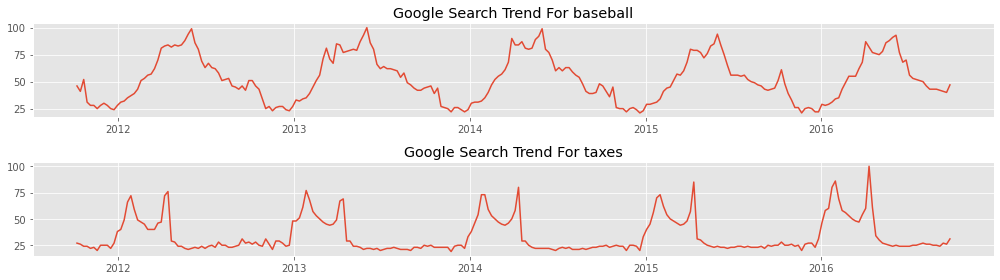

In [86]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_trend_data(axs[0], 'baseball', google_trends['baseball'])
plot_trend_data(axs[1], 'taxes', google_trends['taxes'])
plt.tight_layout()

Just like we can de**trend** a time series, we can also **deseasonalize** a time series.

The simplest method is to create dummy variables at regular intervals of the calender
  - A dummy for each month.
  - A dummy for each season.
  
and then fit a linear regression to the series using these dummy variables.

In [89]:
# pd.get_dummies(google_trends['python'].index.month)

,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
255,0,0,0,0,0,0,0,1,0,0,0,0
256,0,0,0,0,0,0,0,0,1,0,0,0
257,0,0,0,0,0,0,0,0,1,0,0,0
258,0,0,0,0,0,0,0,0,1,0,0,0


In [114]:
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies
    return pd.get_dummies(month).iloc[:, :11]

In [115]:
def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

In [116]:
def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)

Here are linear regression models fit to the baseball and taxes trends with monthly dummy variables.

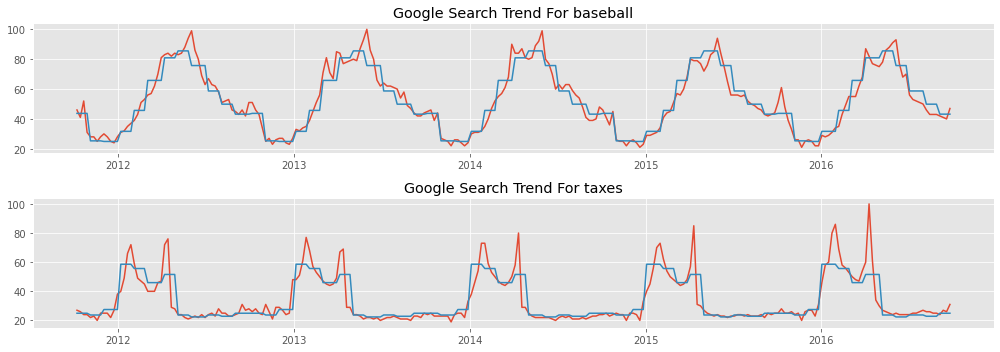

In [117]:
fig, axs = plt.subplots(2, figsize=(14, 5))

plot_seasonal_trend(axs[0], 'baseball', google_trends['baseball'])
plot_seasonal_trend(axs[1], 'taxes', google_trends['taxes'])
plt.tight_layout()

To deseasonalize, we simply subtract out the seasonal predictions.

Text(0.5, 1.0, 'Google Searches for Baseball, Deseasonalized')

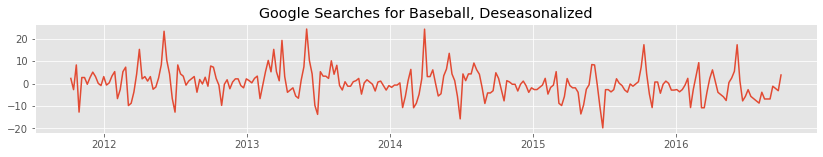

In [118]:
baseball_series = google_trends['baseball']
baseball_seasonal_trend = fit_seasonal_trend(baseball_series)
baseball_seasonal_detrended = baseball_series - baseball_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(baseball_series.index, baseball_seasonal_detrended)
ax.set_title("Google Searches for Baseball, Deseasonalized")

Text(0.5, 1.0, 'Google Searches for Taxes, Deseasonalized')

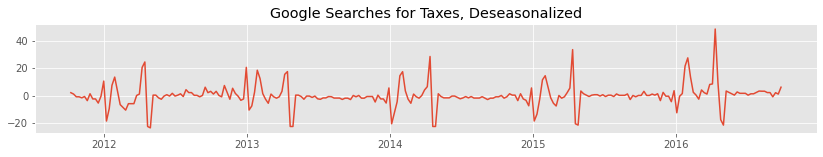

In [119]:
taxes_series = google_trends['taxes']
taxes_seasonal_trend = fit_seasonal_trend(taxes_series)
taxes_seasonal_detrended = taxes_series - taxes_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(taxes_series.index, taxes_seasonal_detrended)
ax.set_title("Google Searches for Taxes, Deseasonalized")

**Question:** Have we removed the seasonality from these series?  What more could we do?

**Activity:** Deseasonalize the `taxes` series.

## Trend-Seasonal-Residual Decomposition

The **Classical Trend-Seasonal-Residual Decomposition** expresses a time series as the sum of three components:

$$ y_t = T_t + S_t + R_t $$

and is accomplished as follows.

Suppose, for definiteness, that we are working with *weekly* data, so that each $52$ observations forms a calender year.  Then, the series is decomposed as follows:

1. Compute the trend component $T_t$ using a moving average with window width $52$ (or $12$ for monthly data.  Then detrend the series.
2. Compute the seasonal component $S_t$ of the detrended series $y_t - T_t$ by averaging together the observations that fall in the same week (or month, if monthly data).  **Note**, this is *equivalent* to fitting a linear regression to the detrended data with an indicator for each week, and then making predictions for each week of the original series.
3. The **remainder**, or **error**, or **residual** series $E_t$ is $y_t - T_t - S_t$.

Statsmodels implements the classical decomposition as `seasonal_decompose`.

In [120]:
python_decomposition = sm.tsa.seasonal_decompose(google_trends['python'])

In [121]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

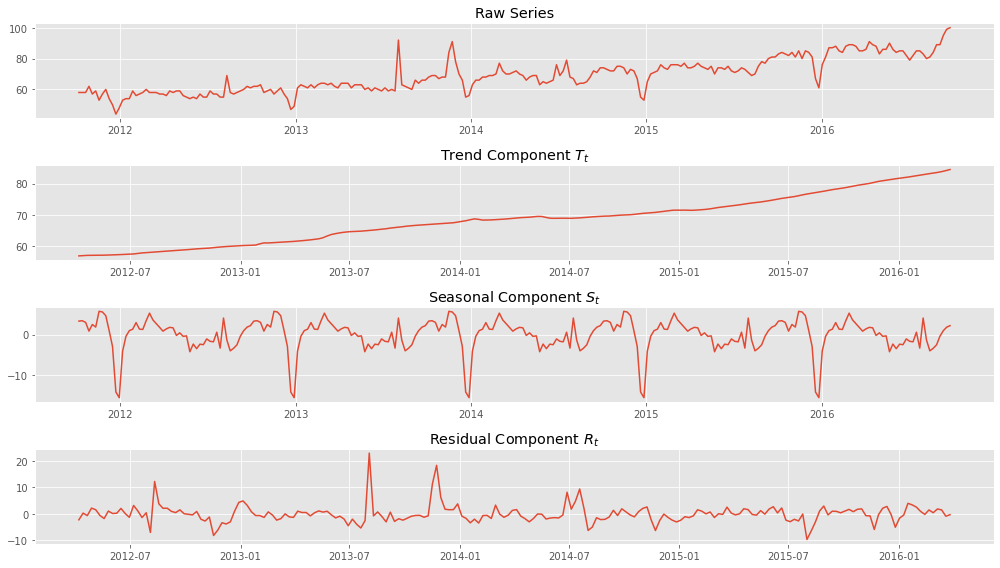

In [122]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['python'], python_decomposition)
plt.tight_layout()

This decomposition validates our description of the series earlier as a general upwards trend, but with some seasonal behaviour (like a sharp drop off in queries around wintertime).

When the decomposition is working well, the residual component $R_t$ should show no seasonal or trend patterns.

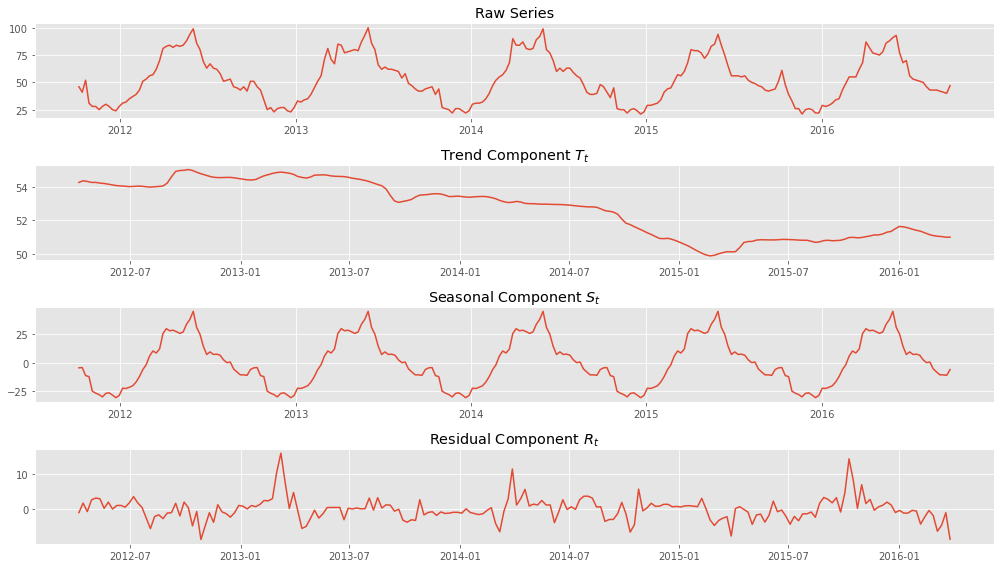

In [123]:
baseball_decomposition = sm.tsa.seasonal_decompose(google_trends['baseball'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['baseball'], baseball_decomposition)
plt.tight_layout()

**Note:** The different components of the series are often shown on very different scales, so make sure to pay close attention to the $y$-axis labels.

Sometimes the classical decomposition is not powerful enough to capture the trend or seasonal components of a time series.

The gmail series decomposition shows some interesting behaviour in the residuals:

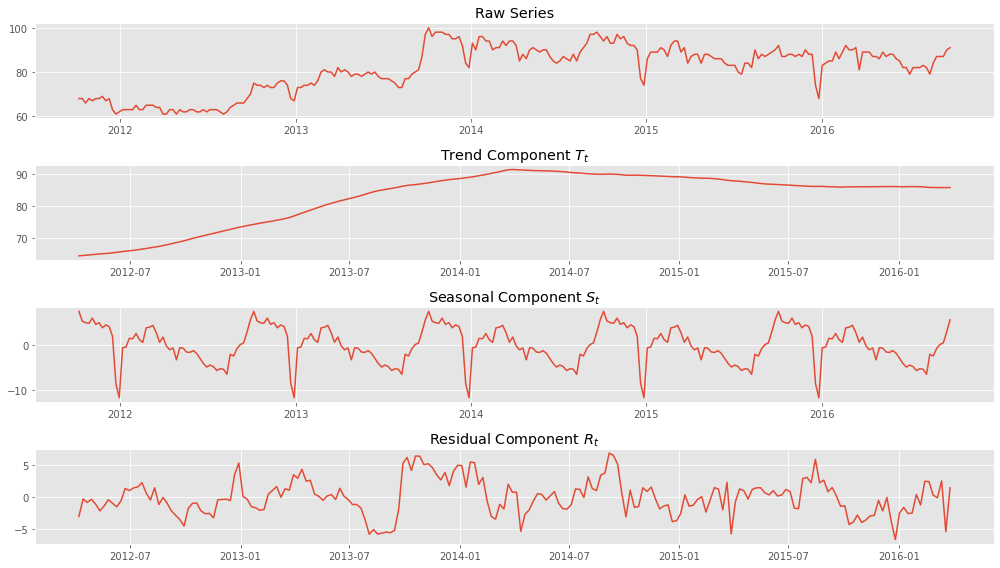

In [124]:
gmail_decomposition = sm.tsa.seasonal_decompose(google_trends['gmail'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['gmail'], gmail_decomposition)
plt.tight_layout()

Around October 2013 the series showed a clear and sudden change in average level, which the trend component could not adapt to quickly enough.  Consequently, this discontinuity appears in the residual series.

A more sophisticated procedure should be used to decompose this series, which allows for a discontinuity in the observed series, or fits a more sophisticated model for the trend component.

Activity: Decompose the data science series. What patterns do you see? Is the decomposition appropriate?

In [126]:
ls data

elec-equip.csv*                search-index-gmail.txt*
globtemp.txt*                  search-index-pokemon.txt*
jj.txt*                        search-index-python.txt*
search-index-baseball.txt*     search-index-taxes.txt*
search-index-blackberry.txt*   search-index-winter.txt*
search-index-data-science.txt* weather_data.csv
search-index-gdp.txt*


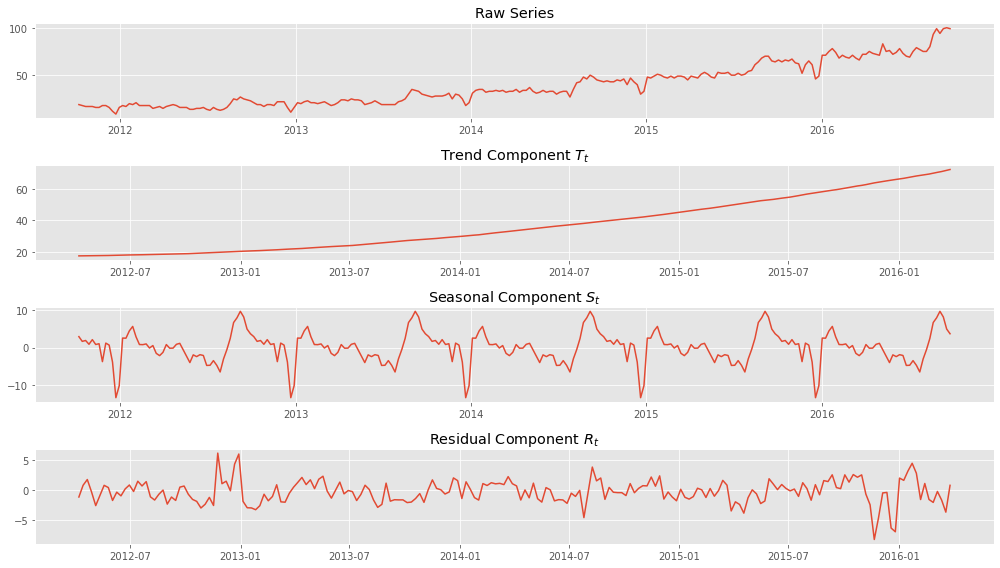

In [127]:
ds_decomposition = sm.tsa.seasonal_decompose(google_trends['data-science'])

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['data-science'], ds_decomposition)
plt.tight_layout()

# Statistical Concepts

## Random Processes

Up to now we have only considered a single manifestation of a single time series

$$ y_1, y_2, y_3, \ldots $$

Let's now impose a probability model on this data, i.e., now we consider series as **random objects that can be sampled**.

Formally, we consider a single time series as a *sample* from a sequence of random variables

$$ Y_1, Y_2, Y_3, \ldots $$

Note that we are **not** assuming that these random variables are independent, **it is very likely that in a time series that sample we draw at time $t$ influences the sample we draw at time $t+1$**.

When we need to distinguish the data from the statistical model that we are assuming generated the data, we call:

  - The data are a **series**.
  - The data generating process a **random process**, or more specifically, a **time-series random process**.

### White Noise 

The simplest possible random process from this perspective occurs when each $Y_i$ is independent from all the rest, and all the $Y$'s are identically distributed with a mean of zero.

In this case the series is called **white noise**.

In [128]:
def white_noise(size=250):
    return pd.Series(np.random.normal(size=size))

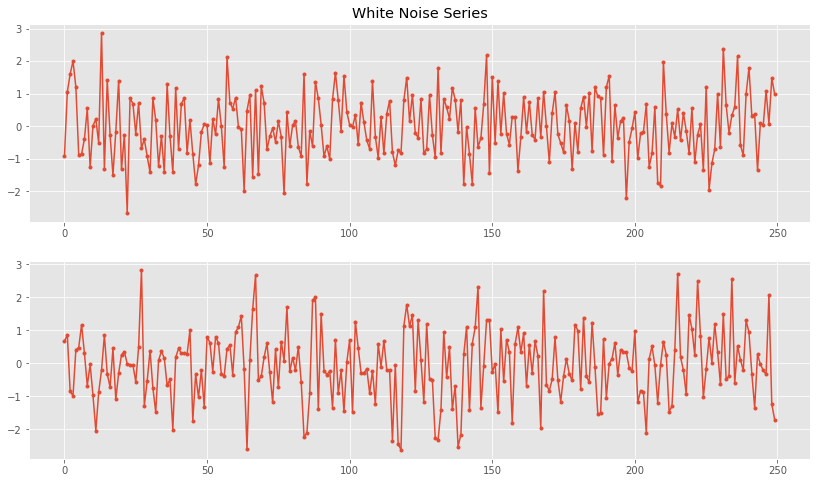

In [129]:
fig, axs = plt.subplots(2, figsize=(14, 8))
for i in range(2):
    noise = white_noise()
    axs[i].plot(noise.index, noise, '.-')
    if i == 0:
        axs[i].set_title("White Noise Series")

White noise shows no trend, no seasonal patterns, no cyclic behavior, and no stickiness.

<!-- If you grab the data set and you take a time slice and you take another slice at a different time chunch, that the distribution in that data is going to be identical.  -->

### Stationarity

A random process $Y_1, Y_2, Y_3, \ldots Y_n$ is said to be **strictly stationary** if the distribution of all time shifted sets taken from the collection are identical.  That is, if

$$ \{Y_{1}, Y_{2}, Y_{3} \ldots, Y_{t}\} $$

and

$$ \{Y_{1 + k}, Y_{2 + k}, Y_{3 + k}\ldots, Y_{t + k}) $$

are identically distributed for all $k$.

This means that the probabilistic properties of the series **do not** depend on when you begin observing it.

This means that if you start observing the series for an hour, go cook a meal for an hour, then observe the series for another hour, the properties of the sequences you observed before and after the meal will be the same!

Strict stationarity is difficult to assess from a single time series and too strong for most applications. In practice, stationarity will refer to **weak stationarity**, where we only require that the mean and variance of the series does not change when shifted in time and the covariance between lagged random variables only depends on the time shift $k$ and not on the specific time point

$$\text{E}(Y_t) = \mu  $$  
$$\text{Var}(Y_t) = \sigma_Y^2$$  
$$\text{Cov}(Y_t, Y_{t + k}) = \gamma(k)$$

**White noise is an example of a stationary process.**

Here are a few series that are **nonstationary**.

In [140]:
a = np.arange(10)
stats.norm(a/50, 1).rvs(10)

array([ 2.04026179,  1.49247196,  1.5418058 ,  0.2568411 , -0.2080152 ,
       -0.55915831,  1.14843349,  0.87273302,  0.6110834 , -0.49141817])

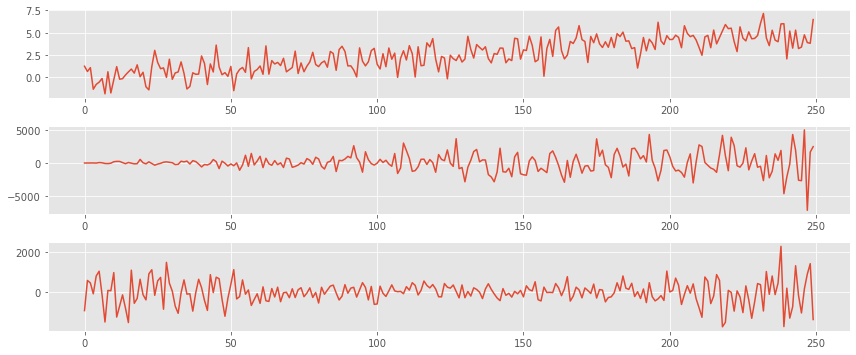

In [131]:
xpts = np.arange(250)
fig, ax = plt.subplots(3, figsize=(12,5))
ypts = stats.norm(xpts/50, 1).rvs(250)
ax[0].plot(xpts, ypts)
ypts = stats.norm(0, xpts*10).rvs(250)
ax[1].plot(xpts, ypts)
ypts = stats.norm(0, (xpts-125)**2/20 + 200).rvs(250)
ax[2].plot(xpts, ypts)
plt.tight_layout()

**Discussion:** Can stationary series show trends?  Can stationary series show seasonality?  Can stationary series be sticky?

To use the ARIMA models introduced later in this course, we will need to transform our time series to stationarity. This will involve removing trends and heteroscedasticity.

### Differencing

<!-- Defining the model to predict the difference in values between time steps rather than the value itself, is a much stronger test of the models predictive powers. -->

In contrast to the detrending and deseasonalizing achieved by decomposition, **differencing** is another method to remove these components.

Given a time series  
$$y_1, y_2, y_3, \ldots y_n$$
the **first difference** series is

$$ y_2 - y_1, y_3 - y_2, y_4 - y_3, \ldots y_n - y_{n - 1}$$

The aim of differencing a series is to remove the trend component, which stationary series cannot have.

In [132]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index.date, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index.date, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

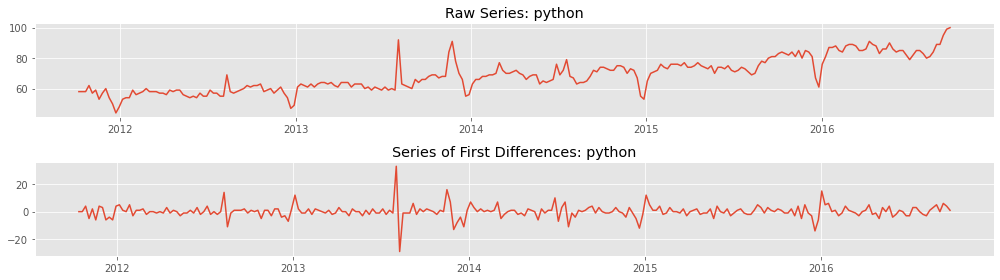

In [133]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['python'], 'python')
fig.tight_layout()

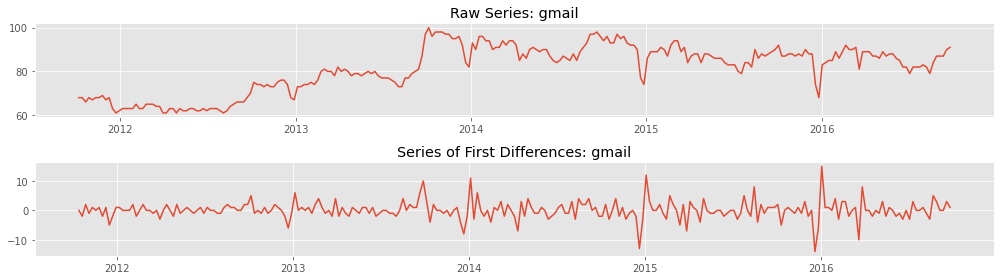

In [134]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['gmail'], 'gmail')
fig.tight_layout()

**Discussion:** Do these difference series look stationary?

**Activity:** Compute and plot the first difference series for `data-science`.  Does it look stationary?

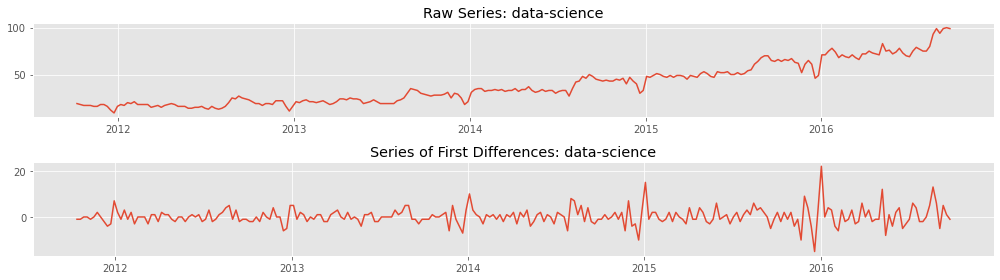

In [135]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, google_trends['data-science'], 'data-science')
fig.tight_layout()

### Random Walks

When a differenced series is *white noise* (**note**: *not all stationary series are white noise*, as we will demonstrate below) we have the following relationship

$$ y_{i+1} - y_i = e_i $$

or 

$$ y_{i+1} = y_i + e_i $$

This type of series is called a **random walk** and is a very common statistical model for time series.

In [142]:
np.cumsum(a)

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

In [143]:
def random_walk(size=250):
    noise = np.random.normal(size=(size + 1))
    walk = np.cumsum(noise)
    return pd.Series(walk)

def plot_random_walk(ax, size=250, color='r', alpha=1):
    walk = random_walk(size=size)
    ax.plot(walk.index, walk, color=color, alpha=alpha)

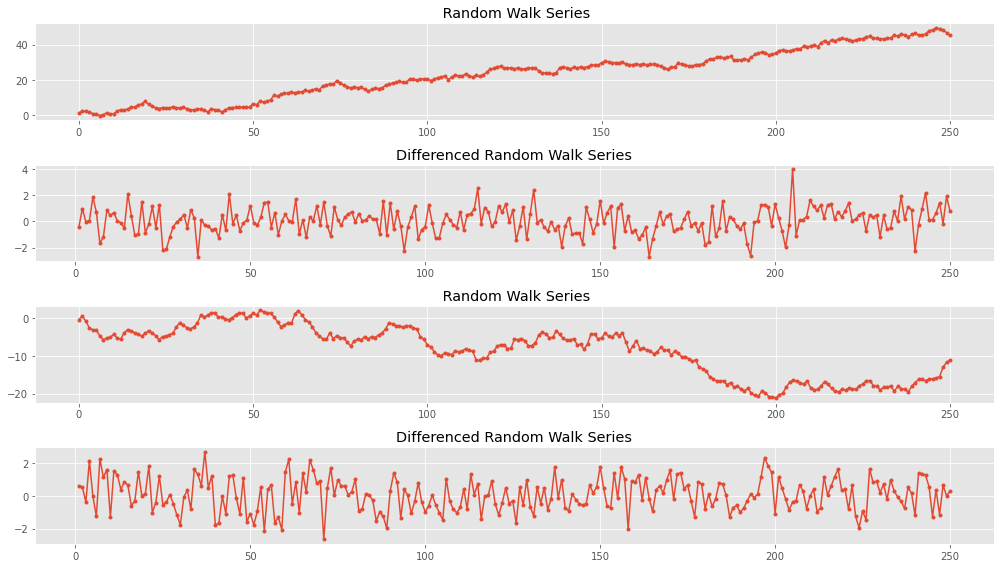

In [144]:
fig, axs = plt.subplots(4, figsize=(14, 8))
for i in range(4):
    walk = random_walk()
    diff = walk.diff()
    if i%2 == 0:
        axs[i].plot(walk.index, walk, '.-')
        axs[i].set_title(" Random Walk Series")
    if i%2 == 1:
        axs[i].plot(diff.index, diff, '.-')
        axs[i].set_title("Differenced Random Walk Series") 
plt.tight_layout()

Notice that random walks, although constructed from totally random components, can show very strong evidence of *trends*.  This is because random walks are sticky, once they randomly elevate to an extreme value, subsequent values of the series are only small adjustments to previous values, so the value of the series tends to stay elevated.

**Take away:**
When you have data that is truly created through a random walk, the best prediction of y for the next period is the current value. 

# Cross Validation in Time Series

Because time series often encode data about the past, it's not appropriate to train on 'future data' to predict 'past data'. We can modify our corss validation to only use past data. 


In [147]:
tickerDf.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04,14.859732,15.452237,14.812602,15.418571,6675700,0.0,0
2010-01-05,15.425306,15.984145,15.418573,15.836020,5317400,0.0,0


0 0
0 1
1 0
1 1


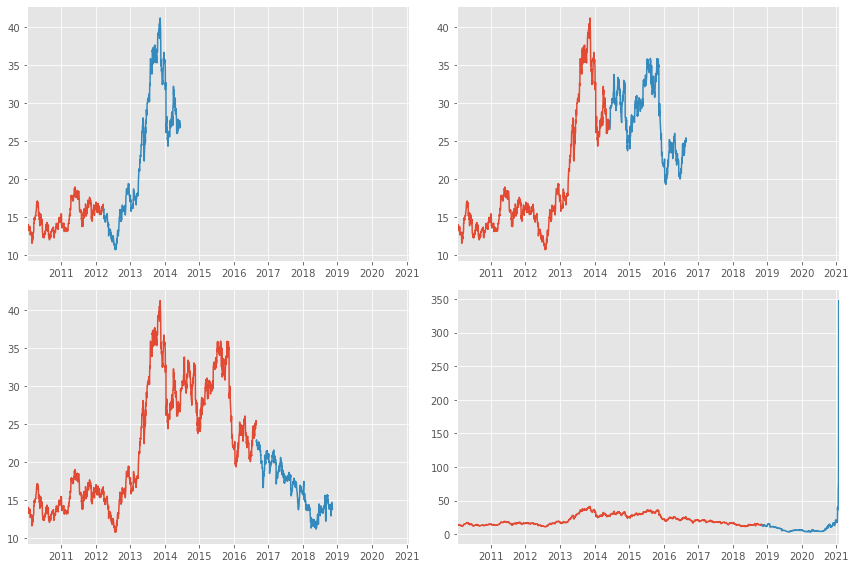

In [146]:
ts_split = TimeSeriesSplit(4)

fig, ax = plt.subplots(2, 2, figsize = (12,8))
years = mdates.YearLocator() 
years_fmt = mdates.DateFormatter('%Y')

for idx, (train_idx, test_idx) in enumerate(ts_split.split(tickerDf)):
    ax[idx // 2, idx % 2].plot(tickerDf.iloc[train_idx]['Close'])
    ax[idx // 2, idx % 2].plot(tickerDf.iloc[test_idx]['Close'])   
    ax[idx // 2, idx % 2].xaxis.set_major_locator(years)
    ax[idx // 2, idx % 2].xaxis.set_major_formatter(years_fmt)
    ax[idx // 2, idx % 2].set_xlim(tickerDf.index.min(), tickerDf.index.max())
    print(idx // 2, idx % 2)
fig.tight_layout()

## Review

- Define a time-series trend and list several ways the trend in a time series could be determined.
- Define a time-series season and explain how seasonality of a time series can be determined.
- Using python, perform trend-season-residual decomposition to make a time-series forecast.
- Describe the difference between a time-series random process and time-series data.
- Explain the problem with cross-validating time-series models and how to do it correctly.


# Talking about Time Series

Do:
- Talk about seasonal affects
- Talk about trends
- Talk about prediction metrics

Avoid:
- Using jargon like 'stationarity', 'autocorrelation'

Maybe:
- Can talk about whether some patterns in residuals are due to data sources not capturing all variability.


______________________________

That's it for today! <b>We will talk about more time series topics in a few weeks. </b>
______________________________

<br><br><br><br><br><br><br><br>

In [159]:
X = pd.DataFrame(google_trends['baseball'])
X['month'] = google_trends['baseball'].index.month
X = pd.get_dummies(X, drop_first = True, columns = ['month'])
X['last_week'] = X['baseball'].shift(-1)
X = X.drop('baseball', 1)

y = google_trends['baseball']

X = X.iloc[:-1]
y = y.iloc[:-1]

In [160]:
X.head()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,last_week
week,,,,,,,,,,,,
2011-10-08,0,0,0,0,0,0,0,0,1,0,0,41.0
2011-10-15,0,0,0,0,0,0,0,0,1,0,0,52.0
2011-10-22,0,0,0,0,0,0,0,0,1,0,0,31.0
2011-10-29,0,0,0,0,0,0,0,0,1,0,0,28.0
2011-11-05,0,0,0,0,0,0,0,0,0,1,0,28.0


In [149]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

ts_split = TimeSeriesSplit(10)

for train_idx, test_idx in ts_split.split(X, y):
    rf = RandomForestRegressor()
    
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    residuals = y_test - y_pred
    print(mean_squared_error(y_test, y_pred, squared=False))
        

9.713165217863684
4.972765687313035
5.787495960352997
3.4130538489295184
6.322180516886184
3.4853861604446927
4.465972570766633
6.446791758770206
2.5727809511775455
5.270335886533483


In [150]:
ts_split = TimeSeriesSplit(10)

for train_idx, test_idx in ts_split.split(X, y):
    rf = RandomForestRegressor(max_depth = 4)
    
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    residuals = y_test - y_pred
    print(mean_squared_error(y_test, y_pred, squared=False))
        

10.63065492659593
4.95204795460201
5.939528123876251
3.1580290608584605
6.65497486217664
3.5948951852034168
4.944265262261859
5.64065342584948
3.962476692609587
5.021258266595984


In [ ]:
gmail_df = pd.DataFrame(google_trends['gmail'])
gmail_df.